# Lesson 6: Ensemble Methods
## Author: Dustin Burnham
### Due: 8/18/2019

Cypress from New Ventures Department has found a banking client who wants to do a targeted marketing campaign for a specialty investment product to some of its customers. Cypress stresses that the bank only wants to spend the effort on customers who are likely to say yes; last year they used a different company to generate an algorithm and ended up spamming many of their customers with products they didn't want.

1. Read in, parse, and pre-process the data
2. Perform a brief exploratory analysis
3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model
4. Graph the structure of your decision tree
5. Graph the confusion matrix of your random forest model

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Read in, parse, and pre-process the data

In [2]:
bank = pd.read_csv("Bank Data.csv")

In [3]:
bank.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


In [4]:
bank.dtypes

age              int64
sex             object
region          object
income         float64
married         object
children         int64
car             object
save_act        object
current_act     object
mortgage        object
pep             object
dtype: object

In [5]:
# Get list of variables to be one hot encoded
cat_vars = list(bank.dtypes.index[bank.dtypes == 'object'])
cat_vars.pop()

'pep'

In [6]:
# Create one hot encoder
handle = "indicator" # error return_nan value indicator
onehoter =  ce.OneHotEncoder(return_df = True,
                       cols = cat_vars,
                       drop_invariant = True,
                       use_cat_names = True, 
                       handle_missing = handle, 
                       handle_unknown = handle)

In [7]:
# Split into train and test sets
bank_features = bank.iloc[:,0:10]
bank_target = bank.iloc[:,10]
bank_target = [1 if tar == 'YES' else 0 for tar in bank_target]
X_train, X_test, y_train, y_test = train_test_split(bank_features, bank_target, test_size = 0.3, random_state=1)

In [8]:
# One hot encode Data
onehoter.fit(X_train)
X_encoded_train = onehoter.transform(X_train)
X_encoded_test = onehoter.transform(X_test)

In [9]:
print("X_train shape = {}".format(X_train.shape))
print("X_encoded_train shape = {}".format(X_encoded_train.shape))

print("X_test shape = {}".format(X_test.shape))
print("X_encoded_test shape = {}".format(X_encoded_test.shape))

X_train shape = (420, 10)
X_encoded_train shape = (420, 19)
X_test shape = (180, 10)
X_encoded_test shape = (180, 19)


In [10]:
X_encoded_test.head()

,age,sex_FEMALE,sex_MALE,region_INNER_CITY,region_RURAL,region_TOWN,region_SUBURBAN,income,married_NO,married_YES,children,car_YES,car_NO,save_act_YES,save_act_NO,current_act_YES,current_act_NO,mortgage_NO,mortgage_YES
446,52,1,0,0,0,1,0,43719.5,0,1,0,0,1,1,0,1,0,1,0
404,24,1,0,1,0,0,0,13864.6,0,1,3,0,1,1,0,1,0,1,0
509,23,1,0,0,1,0,0,11215.3,0,1,2,1,0,1,0,1,0,1,0
455,27,1,0,1,0,0,0,11866.4,0,1,0,1,0,1,0,1,0,1,0
201,46,1,0,0,0,1,0,41627.1,0,1,0,0,1,1,0,1,0,0,1


In [11]:
# Test everything was encoded ok
assert(X_encoded_train.shape[1] == X_encoded_test.shape[1])

### 2. EDA

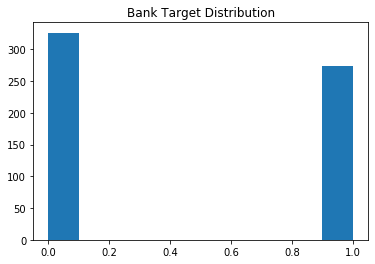

In [12]:
# Check distribution of target
plt.hist(bank_target)
plt.title("Bank Target Distribution")
plt.show()

Use pairplot with color being target to see how each variable is related to the target.

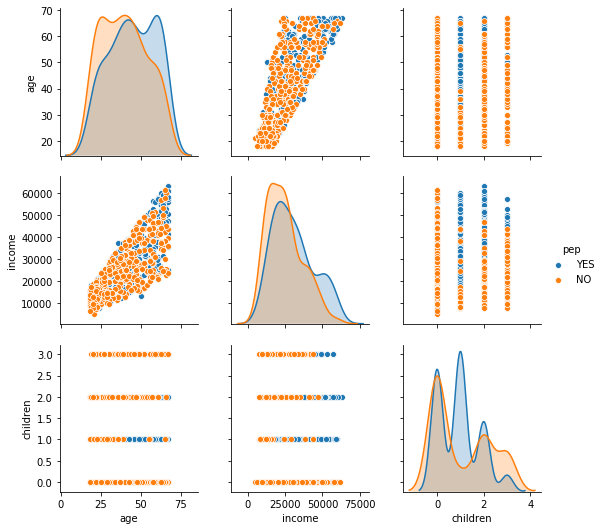

In [13]:
sns.pairplot(bank, hue="pep")

Based off of the EDA, we can see that the targets are well balanced.  In addition, we can notice the following based off of the KDE plots of pairplot:
1. Number of children has the starkest difference between yes and no
2. Individuals that are older are more likely to be a yes
3. Individuals at the upper end of income are also more likely to be a yes

Overall, I expect the number of children to be the most important feature in our decision tree and ensemble methods. 

Next Income and age.

### 3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model

Create dataframe for storing and testing results of different models.  Pick the hyper parameters that create the model with the best score.

In [14]:
results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"])

In [15]:
try:
    results # checks if this object exists or not
except NameError:
    results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"]) # initiates it

In [16]:
# Train random forrest and GB models in functions run tests easier

def rf(x_train, x_test ,y_train, y_test, hparam, df):
    
    clf_rf = RandomForestClassifier(n_estimators = hparam["nTrees"], 
                                max_depth = hparam["max_depth"], 
                                random_state = 0, 
                                min_samples_leaf = hparam["min_leaf_size"],
                                verbose = False)
    
    clf_rf.fit(x_train, y_train)
    
    Y_train_hat = clf_rf.predict(x_train)

    Y_test_hat = clf_rf.predict(x_test)
    
    acc_test = accuracy_score(y_test, Y_test_hat)
    acc_train = accuracy_score(y_train, Y_train_hat)
    
    df.loc[len(results), 0:3] = ["rf", acc_train, acc_test]

    for hp in hparam.keys():
        df.loc[len(df) - 1, hp] = hparam[hp]
    df  
    return(df)

def gb(x_train, x_test ,y_train, y_test, hparam, df):
    
    clf_gb = GradientBoostingClassifier(n_estimators = hparam["nTrees"], 
                                    loss = 'deviance', 
                                    learning_rate = hparam["learning_rate"], 
                                    max_depth = hparam["max_depth"], 
                                    min_samples_leaf = hparam["min_leaf_size"])
    
    clf_gb.fit(x_train, y_train)
    
    Y_train_hat = clf_gb.predict(x_train)

    Y_test_hat = clf_gb.predict(x_test)
    
    acc_test = accuracy_score(y_test, Y_test_hat)
    acc_train = accuracy_score(y_train, Y_train_hat)
    
    df.loc[len(results), 0:3] = ["gb", acc_train, acc_test]

    for hp in hparam.keys():
        df.loc[len(df) - 1, hp] = hparam[hp]
    df  
    return(df)

In [17]:
# Random forrest hyperparameters
hypers_rf = {"nTrees": 50, "max_depth": 11, "min_leaf_size": 5}

In [18]:
# Try out RF hyperparameters
rf(X_encoded_train, X_encoded_test, y_train, y_test, hypers_rf, results)

,algo,acc_train,acc_test,nTrees,max_depth,min_leaf_size
0,rf,0.928571,0.855556,50.0,11.0,5.0


In [19]:
# Gradient boost hyper parameters
hypers_gb = {"nTrees":15, "learning_rate":0.07, "max_depth":10, "min_leaf_size":15}

In [20]:
# Try out GB hyperparameters
gb(X_encoded_train, X_encoded_test, y_train, y_test, hypers_gb, results)

,algo,acc_train,acc_test,nTrees,max_depth,min_leaf_size,learning_rate
0,rf,0.928571,0.855556,50.0,11.0,5.0,NaN
1,gb,0.911905,0.911111,15.0,10.0,15.0,0.07


In [21]:
# Train decision tree.  Pick hyper parameters using cross-validated grid search
from sklearn.model_selection import GridSearchCV
    
hypers_dt = {"max_depth": [15, 20, 25], "max_leaf_nodes": [10, 15, 20]}
clf_dt = DecisionTreeClassifier()
clf = GridSearchCV(clf_dt, hypers_dt, cv=5, iid = False, return_train_score=True)
clf.fit(X_encoded_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'max_depth': [15, 20, 25], 'max_leaf_nodes': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
# Get hyper parameters that maximize performance
scores = list(clf.cv_results_['mean_test_score'])
max_index = scores.index(max(scores))
params = clf.cv_results_['params'][max_index]

In [23]:
print("Max Score:", scores[max_index])
print("Paramters", params)

Max Score: 0.8594876986939355
Paramters {'max_depth': 20, 'max_leaf_nodes': 20}


In [24]:
# Train decision tree, get predictions
clf_dt = DecisionTreeClassifier(max_depth = params['max_depth'], max_leaf_nodes = params['max_leaf_nodes'])
clf_dt.fit(X_encoded_train, y_train)
dt_pred = clf_dt.predict(X_encoded_test)
dt_pred_train = clf_dt.predict(X_encoded_train)

### Train Final Model

In [25]:
# hyperparameters of best performing ensemble method
hypers_gb = {"nTrees": 15, "max_depth": 10, "min_leaf_size": 15, "learning_rate": 0.07}

In [26]:
# Train GB model, create predictions
clf_gb = GradientBoostingClassifier(n_estimators = hypers_gb["nTrees"], 
                                    loss = 'deviance', 
                                    learning_rate = hypers_gb["learning_rate"], 
                                    max_depth = hypers_gb["max_depth"], 
                                    min_samples_leaf = hypers_gb["min_leaf_size"])
    
clf_gb.fit(X_encoded_train, y_train)
    
Y_test_hat = clf_gb.predict(X_encoded_test)

### Evaluate Final Model

In [27]:
# Decision Tree
print(classification_report(dt_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       104
           1       0.86      0.91      0.88        76

   micro avg       0.90      0.90      0.90       180
   macro avg       0.90      0.90      0.90       180
weighted avg       0.90      0.90      0.90       180



In [28]:
# Gradient Boost Ensemble
print(classification_report(Y_test_hat, y_test))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       102
           1       0.89      0.91      0.90        78

   micro avg       0.91      0.91      0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



Decision trees, random forrest, and gradient boost models perform very well looking at the average of various scores, but the random forrest was hard to not overfit so I went with a GB model to test agains the decision tree.  I am surprised that I wasn't able to get the GB model to perform significantly better than the decision tree.  Perhaps this is just a dataset that is simple enough to predict with a simple model.  The GB did just as well on the train as it did on the test, so I'm confident that that the model was not overfit.

### 4. Graph the structure of your decision tree

In [29]:
from sklearn import tree
import os
dotfile = open("dtree.dot", 'w')
tree.export_graphviz(clf_dt, out_file = dotfile, feature_names = list(X_encoded_train))
dotfile.close()
os.environ["PATH"] += os.pathsep + '/Users/dusty/anaconda3/pkgs/graphviz-2.40.1-hefbbd9a_2/lib/graphviz'
os.system('dot -Tpng dtree.dot -o dtree.png')

0

<img src="dtree.png">

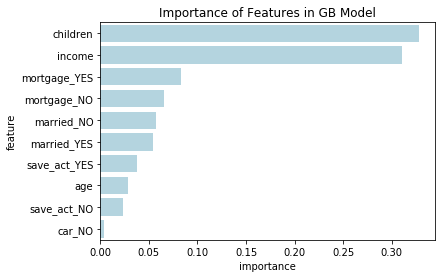

In [30]:
df_var_imp = pd.DataFrame({"feature": X_encoded_train.columns, 
                           "importance": clf_gb.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")
plt.title("Importance of Features in GB Model")
ax

The top two features between the two models are the same.  Children and income.  The decision tree is highly unbalanced, including a couple of leaves do not classify well.  Overall, the decision tree does a good job of identifying "yes" candidates.  However, given the previous experience of the client we should use the gradient boosted ensemble method.

### 5. Graph the confusion matrix of your random forest model

Check performance of GB Model

In [31]:
CM = metrics.confusion_matrix(y_test, Y_test_hat)
tn, fp, fn, tp = CM.ravel()

In [32]:
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  93
False Positive:  7
False Negative:  9
True Positive:  71


Area Under Curve: 0.90875


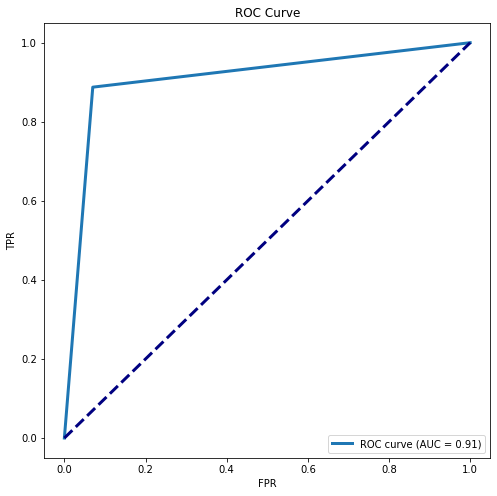

In [33]:
# Generate True Positive Rate, Fale Positive Rate
fpr, tpr, th = roc_curve(y_test, Y_test_hat)

# Generate Area Under the ROC Curve
AUC = auc(fpr, tpr)
print("Area Under Curve:", AUC)

# Generate ROC Plot
plt.rcParams["figure.figsize"] = [8, 8] # Square
plt.figure()
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
plt.legend(loc="lower right")
plt.show()

Both models perform well, but the gradient boosted model has a higher average precision, recall and f1 scores and performs evenly on both train and test (not overfit).  The precision is 91%, so we can feel pretty good that these ads will make it to the right audience without spamming individuals that are likely to say no.  The algorithm isn't perfect, but the company will no doubt feel more comfortable going forward with us (compared to those bad data scientists last summer).